# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2023/24
 * Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
 * Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal, Paul Wollenhaupt
 * Due date: **Tuesday, Nov 21, before 10:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 3-4. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution to the marked cells.

### Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

#### **TODO**
Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.

Hint: Use the package `gdown` to download files from google drive.

```python
!conda install -y gdown
!gdown <file_id>
```

Here's how to find the `file_id`: 
If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [5]:
# TODO Download setup.py from google drive in Kaggle
!conda install -y gdown

Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - file:///tmp/conda
Platform: linux-64

UnavailableInvalidChannel: HTTP 404 UNAVAILABLE OR INVALID for channel conda <file:///tmp/conda>

The channel is not accessible or is invalid.

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.

As of conda 4.3, a valid channel must contain a `noarch/repodata.json` and
associated `noarch/repodata.json.bz2` file, even if `noarch/repodata.json` is
empty. Use `conda index /tmp/conda`, or create `noarch/repodata.json`
and associated `noarch/repodata.json.bz2`.




In [6]:
# TODO import setup.py
import gdown
!gdown --id 1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk

from setup import *

ModuleNotFoundError: No module named 'gdown'

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [ ]:
# TODO define device
device = get_device(True)
device

In [ ]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split and initialize data loaders
trainset, testset = grab_data(data_dir, dataset='CIFAR10')
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size)

#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [ ]:
# TODO define loss function
loss_fct = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

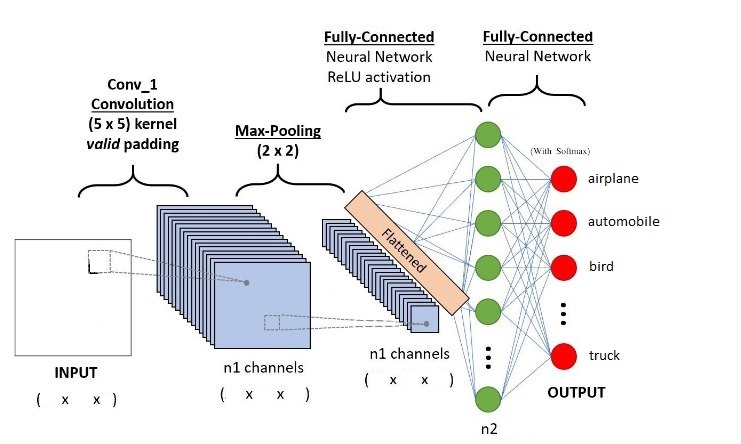

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
- What is the number of parameters for conv_1?

In the context of convolutional neural networks (CNNs), a **feature map** is the output of a convolutional layer applied to the input data. It represents the presence of certain features or patterns in the input. dritte Dimension wird zsmgefasst

**Your answers here**
- Input Dimensions: 32x32x3
- Dimensions of Feature Maps: (Input size - Filter size + 2*Padding)/Stride + 1 = (32 - 5 + 0)/1 + 1 => 28 x 28 x 32 (32 feature maps)
- Dimensions after Pooling: Output Dimensions / 2 => 14 x 14 x 32 (32 feature maps)
- Size of each input to the first fully connected layer: obtained after flattening the output after pooling, thus => 14 x 14 x 32 = 6272
- Number of parameters for the first convolutional layer: 
To calculate the learnable parameters here, all we have to do is just multiply the by the shape of width m, height n, previous layer’s filters d and account for all such filters k in the current layer. Don’t forget the bias term for each of the filter. Number of parameters in a CONV layer would be : ((m * n * d)+1)* k),
(filter size * filter size * input_channels + 1) * number of filters (output channel); +1 is bias term for each feature map;
=> (5 x 5 x 3 + 1) x 32

In [ ]:
# TODO define model

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.model = nn.Sequential(
            # First convolutional layer with 32 filters; kernel size 5*5; stride = 1
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1),
            # Max ppoling layer - kernel size of 2*2
            nn.MaxPool2d(kernel_size = 2), # Default stride is kernel size => 2
            # Flatten
            nn.Flatten(),
            # Fully connected layer with output 128; input is 14x14x32 (after pooling)
            nn.Linear(in_features = 14*14*32, out_features=512),
            # ReLU activation
            nn.ReLU(),
            # Output layer (input 512, output 10 classes)
            nn.Linear(in_features = 512, out_features = 10)        
        )
 
    # Now define forward function that applies all these self methods on input data:
    def forward(self, x):
        result = self.model(x)
        return result

model = SimpleCNN()
model.to(device)

model

Sequential Model:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

In [ ]:
# TODO train and plot
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 10

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, 
                loss_fct, device, epochs, trainloader, valloader, early_stopper=None, verbose=False)# last two are default

#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

In [ ]:
plot('1-layer CNN (10 epochs)', 'Loss', train_losses, val_losses)
plot('1-layer CNN (10 epochs)', 'Accuracy', train_accs, val_accs)

**TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

faster training; less epochs; no convergence yet;
Loss is lower for both training and validation set;
accuracy is higher for both training and validation set;
Overfitting already after few epochs => loss and accuracy do not improve/stagnate



**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

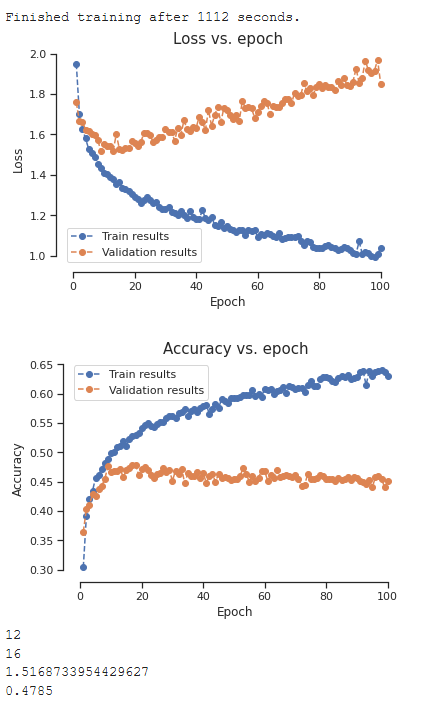

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [ ]:
# TODO train and plot
model60 = SimpleCNN()
model60.to(device)

optimizer = torch.optim.Adam(model60.parameters(), lr)
epochs = 60

train_losses60, val_losses60, train_accs60, val_accs60, confusion_matrix60 = run_training(model60, optimizer, 
                loss_fct, device, epochs, trainloader, valloader)

In [ ]:
plot('1-layer CNN (60 epochs)', 'Loss', train_losses60, val_losses60)
plot('1-layer CNN (60 epochs)', 'Accuracy', train_accs60, val_accs60)

#### **Questions**
- Why is that not an optimal model?
accuracy converges to 1 and loss to 0 for training set; loss for validation set converges against inf => extremely overfitting to training set

- What could be improved?
adding more convolutional layers and filters => detect better structures in images and discover more hierarchial features; reduce parameters to be estimated by more layers and pooling

CNNs are designed to capture hierarchical and spatial features in data through multiple convolutional and pooling layers. A single-layer CNN may lack the capacity to effectively learn complex representations from the data

Limited Capacity for Feature Extraction:

CNNs are powerful because they can automatically learn hierarchical features from the data through multiple convolutional layers. A single convolutional layer has limited capacity to capture complex patterns and relationships in the input data.

Inability to Capture Hierarchical Features:

Deeper architectures allow the network to learn high-level features by combining lower-level features learned in earlier layers. With only one layer, the network may struggle to capture hierarchical representations, leading to a less expressive model.

Insufficient Non-linearity:

CNN architectures typically use non-linear activation functions (e.g., ReLU) to introduce non-linearity into the model. Multiple layers with non-linearities enable the model to learn more complex decision boundaries. A single-layer CNN lacks the depth needed for effective non-linear transformations.

Reduced Model Capacity:

The number of parameters in a single-layer CNN is limited compared to deeper architectures. Increasing the number of layers allows the model to capture more complex relationships in the data, improving its capacity to generalize.

To improve your CNN model:

Add More Convolutional Layers:

Introduce additional convolutional layers to capture hierarchical features and increase the model's capacity to learn complex patterns.
Include Pooling Layers:

Pooling layers help reduce the spatial dimensions of the input data, making the model more robust to variations in scale and orientation. Consider adding pooling layers between convolutional layers.
Increase Model Depth:

Deeper networks often perform better in capturing intricate features. Experiment with increasing the depth of your CNN by adding more convolutional and pooling layers.
Use Regularization Techniques:

Incorporate techniques like dropout or batch normalization to improve the generalization ability of the model and prevent overfitting.
Adjust Hyperparameters:

Experiment with different hyperparameters such as learning rate, batch size, and optimizer to find values that contribute to better convergence and model performance.

## 4. CNN model with more convolutional layers

Sure, let's break down Batch Normalization (BatchNorm) in simpler terms:

### The Problem:
When training a neural network, each layer's input distribution can change during training. This phenomenon is known as "internal covariate shift." It makes the learning process more difficult because the later layers of the network might have to constantly adapt to the changing distribution of inputs from the earlier layers.

### The Solution - Batch Normalization:
Batch Normalization is a technique that helps mitigate the internal covariate shift by normalizing the inputs of a layer across a mini-batch. Here's what it does step by step:

1. **Normalize:**
   - For each feature in the input, BatchNorm normalizes the values to have a mean of 0 and a standard deviation of 1 across the mini-batch.

2. **Scale and Shift:**
   - After normalization, the values are scaled by a learnable parameter (gamma) and shifted by another learnable parameter (beta).
   - This step allows the model to adapt and decide how much of the normalized input should be included in the final output.

### Why BatchNorm Helps:

1. **Stabilizes Training:**
   - By normalizing inputs, BatchNorm helps stabilize and speed up the training of deep neural networks. It reduces the chances of vanishing or exploding gradients.

2. **Reduces Sensitivity to Initialization:**
   - Models with BatchNorm are less sensitive to the choice of weight initialization. This allows for the use of higher learning rates without the risk of divergence.

3. **Acts as a Regularizer:**
   - BatchNorm introduces a bit of noise during training due to the mini-batch statistics, which acts as a form of regularization. This can reduce overfitting.

4. **Enables Faster Training:**
   - Because of the normalization, networks often converge faster, leading to shorter training times.

In summary, Batch Normalization is a technique that helps neural networks train more efficiently and effectively by normalizing the inputs, reducing internal covariate shift, and providing other benefits that contribute to improved learning and generalization.

#### **TODO**
Define the architecture using the following information:



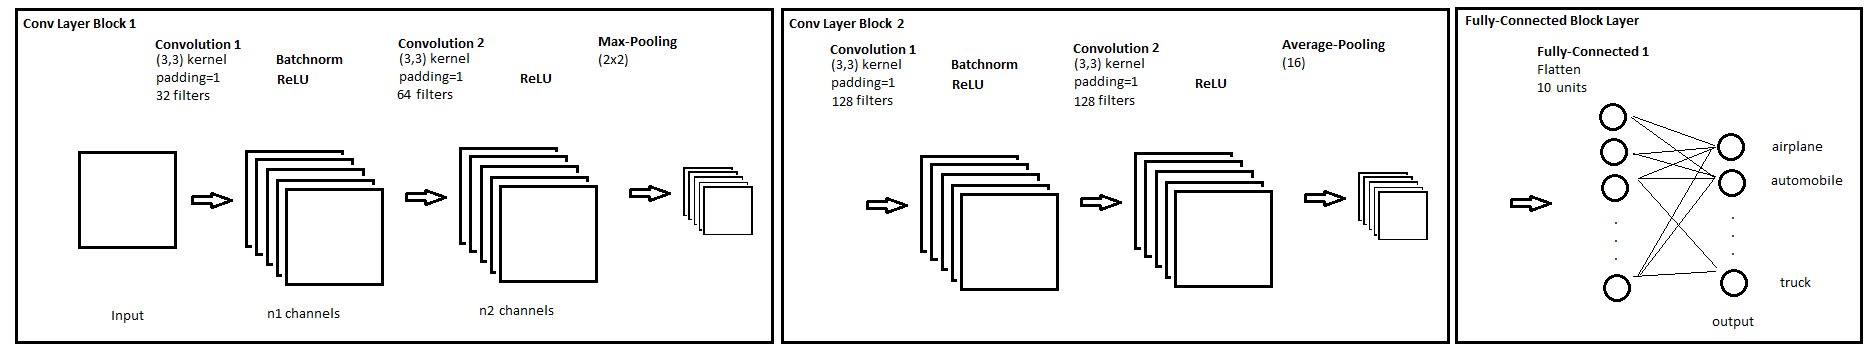

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?

Padding in convolutional layers refers to the process of adding extra pixels around the input data. This is done to ensure that the convolution operation does not reduce the spatial dimensions of the feature maps too much.

Variants:

*Valid (No Padding)*: No extra pixels are added, and the convolution is only performed where the input and filter fully overlap. Reduces size of the feature map
*Same (Zero Padding)*: Padding is added so that the output feature map has the same spatial dimensions as the input feature map. => keeps number of features by adding zeros around the feature map


- What does padding=1 mean in the case of the network displayed above?
In the provided network, padding=1 in the convolutional layers means that one pixel of zero-padding is added to all sides of the input feature maps before performing the convolution. This is typically done to maintain the spatial dimensions of the feature maps.


- What are the dimensions of the feature maps after the 1. conv layer? 
Given the input has dimensions 32x32x3 (3 channels, height H, width W), and applying a convolutional layer with padding=1 and kernel_size=3, the output dimensions would be 
32x32x32 
(last one is number of filters/feature maps)

(Input size - Filter size + 2*Padding)/Stride + 1
(32 - 3 + 2)/1 +1 = 32

- What are the dimensions of the feature maps after the 2. conv layer?
32-3 + 2 + 1 = 32

32x32x64 (64 is the number of filters(feature maps)

=> after pooling: Output Dimensions / 2: 
16 x 16 x 64


- What ist the receptive field size after the first two convolutions?
The receptive field refers to the portion of the input space that a particular neuron in a neural network is sensitive to.
The receptive field size is the effective size of the region in the input space that affects a particular unit in the network. 

Receptive Field = (ReceptiveField_previous - 1) * stride + Kernel size
After first: (1-1)*1 + 3 = 3
After second: (3-1)*1 + 3 = 5 
=> receptive field is 5x5

- What is the value for the in_features for the fully-connected layer?

The in_features for the fully-connected layer is 128. This comes from the number of output channels of the last convolutional layer in the model.

- What is the number of parameters of *Conv Layer block 1*?

Number of parameters=(filter width×filter height×input channels+1)×output channels; + 1 stands for bias term

(3x3x3+1)x32 + (3x3x32+1)x64

**Your answers here**

In [ ]:
#TODO define model 2
import torch.nn as nn

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.model = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),

            # Convolutional layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Convolutional layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Convolutional layer 4
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=16),
        
            # Flatten
            nn.Flatten(),
            # Fully connected layer
            nn.Linear(in_features=128, out_features=10)  
        )

        # Fully connected layer
        

    def forward(self, x):
        x = self.model(x)
        return x

model_improved = ImprovedCNN()
model_improved.to(device)

model_improved



#### **TODO** 

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot
lr = 0.1
optimizer = torch.optim.Adam(model_improved.parameters(), lr)
epochs = 30

train_losses2_30, val_losses2_30, train_accs2_30, val_accs2_30, confusion_matrix2_30 = run_training(model_improved, optimizer, 
                loss_fct, device, epochs, trainloader, valloader)

In [ ]:
plot('Multi-layer CNN (30 epochs)', 'Loss', train_losses2_30, val_losses2_30)
plot('Multi-layer CNN (30 epochs)', 'Accuracy', train_accs2_30, val_accs2_30)

Observation: very good accuracy and loss compared to 1-layer CNN (validation set); no no overfitting since validation and training stats are quite similar
Explanation: -Because more layers can identify patterns better, see above

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

F(x) is the residual function. H(x) is the desired mapping. x = input


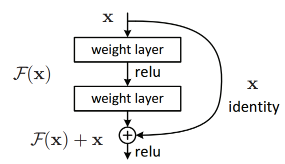

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 

- it solves the problem of vanishing gradients:  In deep neural networks, as gradients are propagated backward during training, they can become very small, making it difficult for the network to learn effectively. By providing shortcut connections that skip one or more layers, the gradient information can more easily flow through the network. This allows for the training of deep networks without the degradation of the gradient signal.
Makes it easier to train very deep networks. Traditional deep networks might struggle to converge or learn meaningful representations due to the challenges associated with propagating gradients through numerous layers. Skip connections enable the training of deep networks by allowing the direct flow of information from the input to deeper layers.
    => solves problem of diminishing gradients

- Instead of learning the direct mapping from input to output in a layer, ResNet focuses on learning the residual or the difference between the input and output. 


Mathematically, if H(x) represents the desired mapping of the layer, ResNet learns the residual function F(x) = H(x) - x. The output of the layer then becomes F(x) + x.

The concept of residuals is inspired by the idea that it might be easier for a neural network to learn the residual function (the change) rather than the entire mapping. By doing so, the network can avoid the vanishing gradients problem, making it easier to train deep networks. The term "residual" emphasizes this focus on learning the residual function and the incorporation of shortcut connections to add the original input to the learned residuals, facilitating the training of very deep neural networks.

In the context of a neural network layer, the desired mapping represents the relationship between the input and the corresponding output that the network is trying to capture.

Input (x):
In a neural network, the input (x) is the data that is fed into the network. For example, in an image recognition task, the input might be an image.

Desired Mapping (H(x)): The desired mapping (H(x)) represents the ideal transformation or function that the neural network should learn for a given input. It's what we want the network to approximate or model. In the context of image recognition, H(x) might represent the true mapping of features in the input image to the correct class labels.

Residual Function (F(x)): The residual function (F(x)) is the part that ResNet focuses on learning. Instead of learning the entire mapping H(x), ResNet learns the residual, which is the difference between the desired mapping and the input: F(x) = H(x) - x. Learning the residual is thought to be easier than learning the entire mapping, especially in deep networks.

Output (F(x) + x): The output of a ResNet layer is the sum of the learned residual and the original input. So, the output becomes F(x) + x. This output is then passed to the next layer in the network.



#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

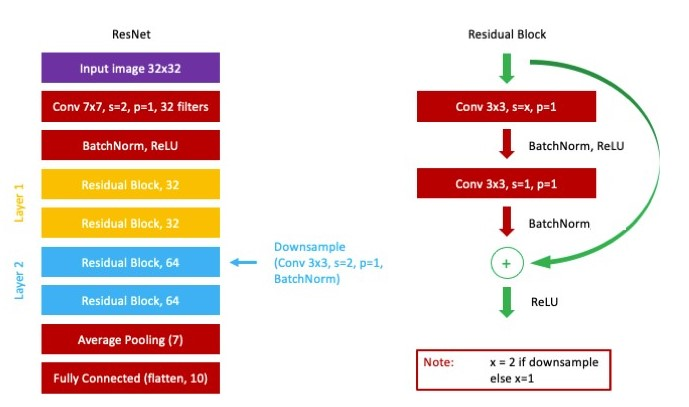

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet


In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model


In [ ]:
# TODO train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.


In [ ]:
# TODO Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.


#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
- In deeper networks, how would you expect residual blocks to influence training time? why?
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from setup.py here and create a new method here 
# or just change/create a new method it in the python file)



In [ ]:
# TODO train and plot with step size 1, gamma 0.1



In [ ]:
# TODO train and plot with step size 1, gamma 0.9



#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.



## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

In [ ]:
# TODO train and plot with different schedulers

**Your answers here**